# **Import**

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

# **Data Load**

In [3]:
cd /content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data

/content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data


In [4]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i + 1}' for i in range(21)]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('./train_FD004.csv')

In [5]:
max_cycle = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

train_df = train_df.merge(max_cycle, on='unit_number', how='left')

train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

# **Model**

In [6]:
features = [
    'unit_number', 'time_cycles',
    's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
    's_11','s_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
    's_20', 's_21', 'RUL'
]
train_df = train_df[features]
train_df.head()

,unit_number,time_cycles,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,445.00,548.70,1341.24,1118.03,3.91,5.70,137.98,2211.88,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,462.54,536.10,1255.23,1033.59,7.05,9.00,174.82,1915.22,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [7]:
agg_features = []
using_sensor = [
    's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
    's_11','s_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
    's_20', 's_21'
]

for unit in train_df['unit_number'].unique():
    unit_data = train_df[train_df['unit_number'] == unit]
    for t in range(2, len(unit_data)+1):  # 최소 2개 시점부터
        sub_data = unit_data.iloc[:t]  # 1~t
        features = {'unit_number': unit, 'time_cycles': sub_data['time_cycles'].iloc[-1]}

        for sensor in using_sensor:
            features[f'{sensor}_mean'] = sub_data[sensor].mean()
            features[f'{sensor}_std'] = sub_data[sensor].std()
            features[f'{sensor}_min'] = sub_data[sensor].min()
            features[f'{sensor}_max'] = sub_data[sensor].max()
            features[f'{sensor}_last'] = sub_data[sensor].iloc[-1]
            features[f'{sensor}_median'] = sub_data[sensor].median()
            # trend는 최소 2개 이상 시점에서만 계산 가능
            features[f'{sensor}_trend'] = np.polyfit(sub_data['time_cycles'], sub_data[sensor], 1)[0]

        # RUL은 해당 시점에서 남은 수명
        features['RUL'] = sub_data['RUL'].iloc[-1]

        agg_features.append(features)

agg_df = pd.DataFrame(agg_features)

In [8]:
agg_df.head()

,unit_number,time_cycles,s_1_mean,s_1_std,s_1_min,s_1_max,s_1_last,s_1_median,s_1_trend,s_2_mean,...,s_20_median,s_20_trend,s_21_mean,s_21_std,s_21_min,s_21_max,s_21_last,s_21_median,s_21_trend,RUL
0,1,2,468.095000,32.661262,445.0,491.19,491.19,468.095,4.619000e+01,577.875000,...,17.495,13.750000,10.511100,5.860642,6.367,14.6552,14.6552,10.51110,8.288200,319
1,1,3,460.396667,26.667809,445.0,491.19,445.00,445.000,-1.044520e-13,568.233333,...,10.620,-0.070000,9.147833,4.769597,6.367,14.6552,6.4213,6.42130,0.027150,318
2,1,4,456.547500,23.095000,445.0,491.19,445.00,445.000,-4.619000e+00,563.350000,...,10.580,-1.413000,8.465275,4.126691,6.367,14.6552,6.4176,6.41945,-0.808210,317
3,1,5,457.746000,20.179601,445.0,491.19,462.54,445.000,-1.111000e+00,557.900000,...,10.620,-0.701000,8.507300,3.575054,6.367,14.6552,8.6754,6.42130,-0.362080,316
4,1,6,456.361667,18.364947,445.0,491.19,449.44,447.220,-1.821429e+00,557.378333,...,12.325,-0.271714,8.573700,3.201760,6.367,14.6552,8.9057,7.54835,-0.149989,315


In [9]:
x = agg_df.drop(['unit_number','RUL'], axis=1)
y = agg_df['RUL']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## **XGBoost**

In [10]:
xgb_model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05)
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_val)

In [11]:
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
xgb_mae = mean_absolute_error(y_val, xgb_pred)

print(f"RMSE: {xgb_rmse:.3f}, MAE: {xgb_mae:.3f}")

RMSE: 8.317, MAE: 5.740


## **LightGBM**

In [12]:
lgb_model = LGBMRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, verbose=-1)
lgb_model.fit(x_train, y_train)
lgb_pred = lgb_model.predict(x_val)

In [13]:
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
lgb_mae = mean_absolute_error(y_val, lgb_pred)

print(f"RMSE: {lgb_rmse:.3f}, MAE: {lgb_mae:.3f}")

RMSE: 10.072, MAE: 7.164


# **Predict RUL**

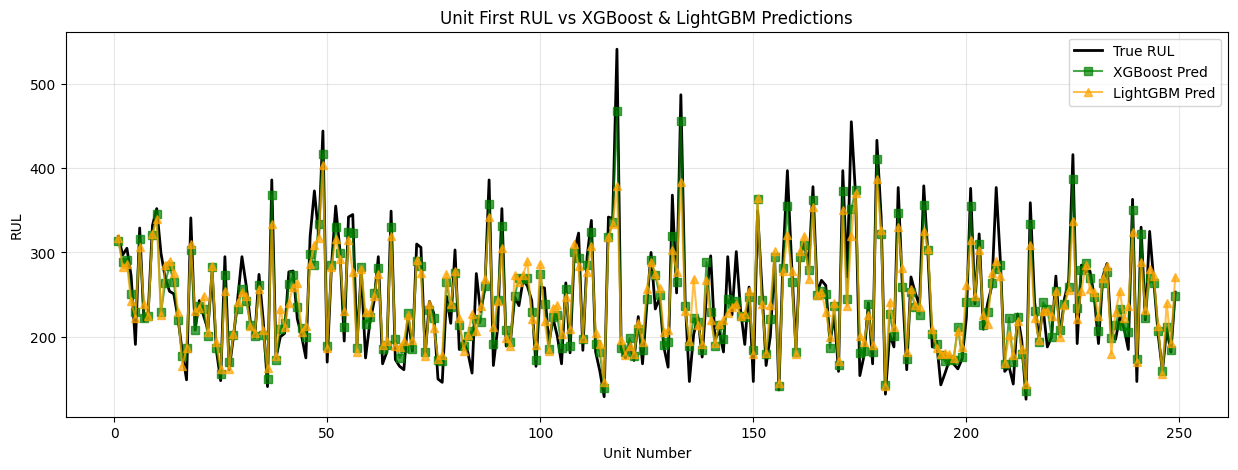

In [14]:
unit_ids = agg_df['unit_number'].unique()
rul_df = agg_df.groupby('unit_number')['RUL'].max().reset_index()

true_first_rul = []
xgb_first_pred = []
lgb_first_pred = []

for unit in unit_ids:
    unit_rows = agg_df[agg_df['unit_number'] == unit]
    first_idx = unit_rows.index[0]

    true_first_rul.append(rul_df.loc[unit-1, 'RUL'])  # test set일 경우 RUL_FD001.csv 사용
    xgb_first_pred.append(xgb_model.predict(unit_rows.drop(['unit_number','RUL'], axis=1).iloc[[0]])[0])
    lgb_first_pred.append(lgb_model.predict(unit_rows.drop(['unit_number','RUL'], axis=1).iloc[[0]])[0])

df_compare = pd.DataFrame({
    'unit_number': unit_ids,
    'True_RUL': true_first_rul,
    'XGB_RUL': xgb_first_pred,
    'LGBM_RUL': lgb_first_pred
})

plt.figure(figsize=(15,5))
plt.plot(df_compare['unit_number'], df_compare['True_RUL'], label='True RUL', color='black', linewidth=2)
plt.plot(df_compare['unit_number'], df_compare['XGB_RUL'], label='XGBoost Pred', color='green', marker='s', alpha=0.7)
plt.plot(df_compare['unit_number'], df_compare['LGBM_RUL'], label='LightGBM Pred', color='orange', marker='^', alpha=0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL')
plt.title('Unit First RUL vs XGBoost & LightGBM Predictions')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# **Test**

In [15]:
test_df = pd.read_csv('./test_FD004.csv')
rul_df = pd.read_csv('./RUL_FD004.csv')

In [17]:
features = [
    'unit_number', 'time_cycles',
    's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
    's_11','s_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
    's_20', 's_21'
]
test_df = test_df[features]
test_df.head()

,unit_number,time_cycles,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,491.19,606.67,1481.04,1227.81,9.35,13.60,332.52,2323.67,...,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007
1,1,2,462.54,536.22,1256.17,1031.48,7.05,9.00,174.46,1915.21,...,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748
2,1,3,445.00,549.23,1340.13,1105.88,3.91,5.69,137.34,2211.93,...,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365
3,1,4,445.00,549.19,1339.70,1107.26,3.91,5.69,137.23,2211.89,...,129.48,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367
4,1,5,449.44,555.10,1353.04,1117.80,5.48,7.97,192.94,2222.71,...,181.82,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326


In [18]:
agg_features = []
using_sensor = [
    's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
    's_11','s_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
    's_20', 's_21'
]

for unit in test_df['unit_number'].unique():
    unit_data = test_df[test_df['unit_number'] == unit]
    features = {'unit_number': unit, 'time_cycles': unit_data['time_cycles'].max()}

    for sensor in using_sensor:
        features[f'{sensor}_mean'] = unit_data[sensor].mean()
        features[f'{sensor}_std'] = unit_data[sensor].std()
        features[f'{sensor}_min'] = unit_data[sensor].min()
        features[f'{sensor}_max'] = unit_data[sensor].max()
        features[f'{sensor}_last'] = unit_data[sensor].iloc[-1]
        features[f'{sensor}_median'] = unit_data[sensor].median()
        features[f'{sensor}_trend'] = np.polyfit(unit_data['time_cycles'], unit_data[sensor], 1)[0]  # 선형 추세

    agg_features.append(features)

agg_df = pd.DataFrame(agg_features)

In [19]:
agg_df.head()

,unit_number,time_cycles,s_1_mean,s_1_std,s_1_min,s_1_max,s_1_last,s_1_median,s_1_trend,s_2_mean,...,s_20_last,s_20_median,s_20_trend,s_21_mean,s_21_std,s_21_min,s_21_max,s_21_last,s_21_median,s_21_trend
0,1,230,473.540565,25.773124,445.0,518.67,462.54,462.54,0.008187,580.125696,...,14.41,14.960,0.004305,12.491842,5.756966,6.2367,23.5819,8.6329,8.97420,0.002534
1,2,153,474.393660,26.086640,445.0,518.67,445.00,462.54,-0.077132,580.574510,...,10.58,14.980,-0.023945,12.688261,5.898187,6.2058,23.5112,6.4325,9.00250,-0.014446
2,3,141,473.160851,27.890203,445.0,518.67,445.00,462.54,0.087741,579.936383,...,10.61,14.960,0.036558,12.671770,6.324453,6.2863,23.5553,6.3488,8.92530,0.022129
3,4,208,473.131394,26.044476,445.0,518.67,462.54,462.54,0.036914,580.734952,...,14.41,14.945,0.013299,12.545607,5.793835,6.2548,23.5067,8.5696,8.98695,0.007858
4,5,51,469.132745,26.465308,445.0,518.67,462.54,462.54,0.003972,574.079216,...,14.19,14.250,0.002653,11.700724,6.109493,6.1834,23.3713,8.6248,8.63290,0.001110


In [20]:
x_test = agg_df.drop(['unit_number'], axis=1)
y_test = rul_df['RUL']

In [21]:
xgb_pred = xgb_model.predict(x_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)

print(f"RMSE: {xgb_rmse:.3f}, MAE: {xgb_mae:.3f}")

RMSE: 38.993, MAE: 27.412


In [22]:
lgb_pred = lgb_model.predict(x_test)

lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_mae = mean_absolute_error(y_test, lgb_pred)

print(f"RMSE: {lgb_rmse:.3f}, MAE: {lgb_mae:.3f}")

RMSE: 38.614, MAE: 27.737


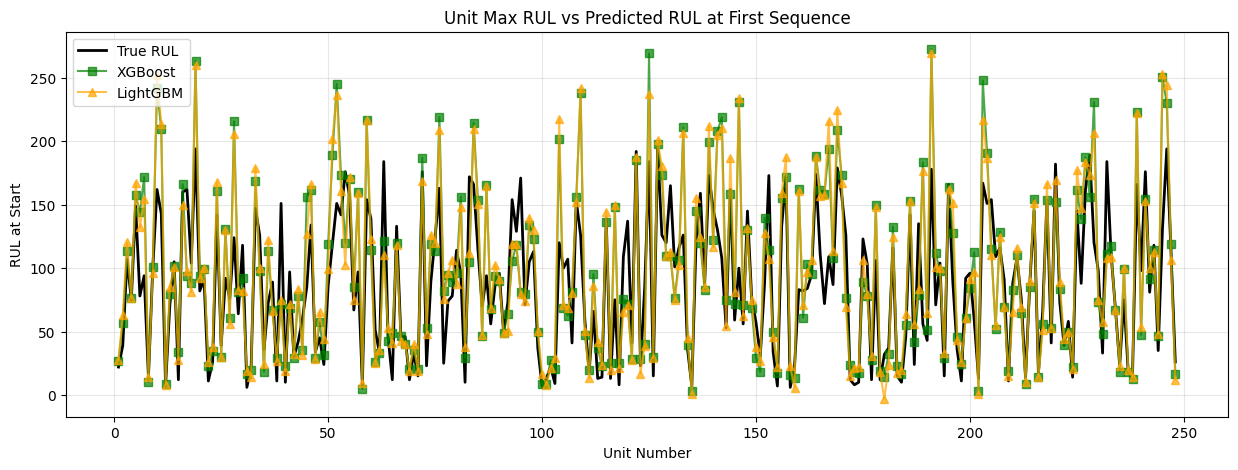

In [23]:
unit_ids = agg_df['unit_number']
true_max_rul = rul_df['RUL']

xgb_pred_full = xgb_model.predict(x_test)
lgb_pred_full = lgb_model.predict(x_test)

df_rul_compare = pd.DataFrame({
    'unit_number': unit_ids,
    'True_RUL': true_max_rul,
    'XGB_RUL': xgb_pred_full,
    'LGBM_RUL': lgb_pred_full
})

plt.figure(figsize=(15,5))
plt.plot(df_rul_compare['unit_number'], df_rul_compare['True_RUL'], label='True RUL', color='black', linewidth=2)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['XGB_RUL'], label='XGBoost', color='green', marker='s', alpha=0.7)
plt.plot(df_rul_compare['unit_number'], df_rul_compare['LGBM_RUL'], label='LightGBM', color='orange', marker='^', alpha=0.7)

plt.xlabel('Unit Number')
plt.ylabel('RUL at Start')
plt.title('Unit Max RUL vs Predicted RUL at First Sequence')
plt.legend()
plt.grid(alpha=0.3)
plt.show()